In [1]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.2 MB/s eta 0:00:00


In [2]:
#Packages: import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#**Load Dataset and Preprocces:**

In [3]:
# Path to images and annotations
path_images = "/101_ObjectCategories/airplanes/"
path_annot = "/Annotations/Airplanes_Side_2/"

#Download the dataset:To detect airplanes (Here only there is an class, so that in this case every bounding box only has 4 attrubutes) and for every image we will only have 1 annotation.
path_to_downloaded_file = keras.utils.get_file(
    fname="caltech_101_zipped",
    origin="https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip",
    extract=True,
    archive_format="zip",  # downloaded file format
    cache_dir="/",  # cache and extract in current directory
)

# Extracting tar files found inside main zip file
shutil.unpack_archive("/datasets/caltech-101/101_ObjectCategories.tar.gz", "/")
shutil.unpack_archive("/datasets/caltech-101/Annotations.tar", "/")

# list of paths to images and annotations
image_paths = [
    f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))
]
annot_paths = [
    f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))
]

image_paths.sort()
annot_paths.sort()

image_size = 224  # resize input images to this size

images, targets = [], []

# loop over the annotations and images, preprocess them and store in lists
for i in range(0, len(annot_paths)):
    # Access bounding box coordinates
    annot = scipy.io.loadmat(path_annot + annot_paths[i])["box_coord"][0] #Load the annotation of the bounding boxes of the image

    #Attributes of the bounding box:
    top_left_x, top_left_y = annot[2], annot[0]
    bottom_right_x, bottom_right_y = annot[3], annot[1]

    image = keras.utils.load_img(
        path_images + image_paths[i],
    ) #Load the image
    (w, h) = image.size[:2] # Original width and hight of the image

    # resize train set images (80% of the image for train)
    if i < int(len(annot_paths) * 0.8):
        # resize image if it is for training dataset
        image = image.resize((image_size, image_size))

    # convert image to array and append to list (All the image will be in this list)
    images.append(keras.utils.img_to_array(image))

    # apply relative scaling to bounding boxes as per given image and append to list (Normalize the coordenates of the bounding box. All the bounding boxes will be in the list)
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )

# Convert the list to numpy array, split to train and test dataset (80% for train and 20% for test)
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)

137414764/137414764 [==============================] - 6s 0us/step


<ipython-input-3-249d960e4d09>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(images[int(len(images) * 0.8) :]),


In [5]:
def mlp(x, hidden_units, dropout_rate):
  """
  DESCRIPTION: Function for define the architecture of the sublayer 2 of every identical layer of the encoder transformer (MLP).
  ------------------------------------------------------------------------------------------------------------------------------
  ------------------------------------------------------------------------------------------------------------------------------
  PARAMETERS:
  - x (tensor): Input Tensor to the sublayer 2 (MLP).
  - dropout_rate (float): dropout rate in the MLP.
  - hidden_units (list):List  with the umber of neurons of  every dense layer.
  ------------------------------------------------------------------------------------------------------------------------------
  ------------------------------------------------------------------------------------------------------------------------------
  RETURN:
  - x (tensor): Output tensor of the sublayer 2 (MLP)
  """
  for units in hidden_units:
      x = layers.Dense(units, activation=tf.nn.gelu)(x)
      x = layers.Dropout(dropout_rate)(x)
  return x

In [6]:
x_train.shape #640 images in RGB for train

(640, 224, 224, 3)

In [7]:
class Patches(layers.Layer):
  """
  Class for dividing images into patches.

  This class inherits from `layers.Layer` in TensorFlow and is used to divide images into patches
  as part of the data preprocessing.

  Args:
      patch_size (int): Size of the patch. Each patch will be a square of size patch_size x patch_size.

  Attributes:
      patch_size (int): The patch size specified during initialization.

  Raises:
      None

  Returns:
      None
  """
  def __init__(self, patch_size):
      super().__init__()
      self.patch_size = patch_size

  def get_config(self):
      """
      Function to get the configuration of the current instance of the class.

      This is useful for saving and loading models in TensorFlow/Keras.

      Args:
          None

      Returns:
          dict: A dictionary containing the current configuration of the class.
      """
      config = super().get_config().copy()
      config.update({"patch_size": self.patch_size})
      return config

  def call(self, images):
      """
      Function that divides images into patches.

      Args:
          images (tf.Tensor): A tensor containing a batch of images.

      Returns:
          tf.Tensor: A tensor containing the patches extracted from the images.
      """
      batch_size = tf.shape(images)[0]
      patches = tf.image.extract_patches(
          images=images,
          sizes=[1, self.patch_size, self.patch_size, 1],
          strides=[1, self.patch_size, self.patch_size, 1],
          rates=[1, 1, 1, 1],
          padding="VALID",
      )
      return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])


Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


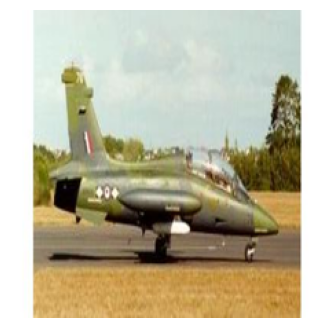

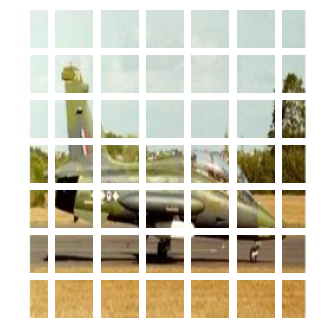

In [8]:
#Showing the images and your patches:

patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch") #per image we will have 49 pacthes of lenght 224x224x3

#plot the image and the patches:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [9]:
class PatchEncoder(layers.Layer):
  """
  Class for encoding patches.

  This class inherits from `layers.Layer` in TensorFlow and is used to encode patches
  as part of the data preprocessing.

  Args:
      num_patches (int): Number of patches extracted from the image.
      projection_dim (int): Dimension of the projected patch.

  Attributes:
      num_patches (int): The number of patches specified during initialization.
      projection (tf.keras.layers.Dense): A dense layer for projecting the patch to the desired dimension.
      position_embedding (tf.keras.layers.Embedding): An embedding layer for representing the positional information.

  Raises:
      None

  Returns:
      None
  """
  def __init__(self, num_patches, projection_dim):
      super().__init__()
      self.num_patches = num_patches
      self.projection = layers.Dense(units=projection_dim)
      self.position_embedding = layers.Embedding(
          input_dim=num_patches, output_dim=projection_dim
      )

  def get_config(self):
      """
      Function to get the configuration of the current instance of the class.

      This is useful for saving and loading models in TensorFlow/Keras.

      Args:
          None

      Returns:
          dict: A dictionary containing the current configuration of the class.
      """
      config = super().get_config().copy()
      config.update(
          {
              "num_patches": self.num_patches,
              "projection_dim": self.projection.units,
          }
      )
      return config

  def call(self, patch):
      """
      Function that encodes the patches.

      Args:
          patch (tf.Tensor): A tensor containing a patch extracted from the image.

      Returns:
          tf.Tensor: A tensor containing the encoded patch with positional information.
      """
      positions = tf.range(start=0, limit=self.num_patches, delta=1)
      encoded = self.projection(patch) + self.position_embedding(positions)
      return encoded


In [12]:
def create_vit_object_detector(input_shape,patch_size,num_patches,projection_dim,num_heads,transformer_units,transformer_layers,mlp_head_units):
  """
  Function to create an object detector using Vision Transformer (ViT).

  This function creates a ViT model for object detection in images.

  Args:
      input_shape (tuple): Shape of the input images (height, width, channels).
      patch_size (int): Size of the patch. Each patch will be a square of size patch_size x patch_size.
      num_patches (int): Number of patches extracted from the image.
      projection_dim (int): Dimension of the projected patch.
      num_heads (int): Number of heads in the attention layer.
      transformer_units (list): List of integers representing the number of units in the MLP layers of the Transformer block.
      transformer_layers (int): Number of identical layers in the encoder transformer.
      mlp_head_units (list): List of integers representing the number of units in the MLP layers of the head of the model.

  Returns:
      keras.Model: The ViT model for object detection.
  """
  inputs = layers.Input(shape=input_shape)
  # Create patches
  patches = Patches(patch_size)(inputs)
  # Encode patches
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  # Create multiple layers of the Transformer block.
  for _ in range(transformer_layers):
      # Layer normalization 1.
      x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
      # Create a multi-head attention layer.
      attention_output = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=projection_dim, dropout=0.1
      )(x1, x1)
      # Skip connection 1.
      x2 = layers.Add()([attention_output, encoded_patches])
      # Layer normalization 2.
      x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
      # MLP
      x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
      # Skip connection 2.
      encoded_patches = layers.Add()([x3, x2])

  # Create a [batch_size, projection_dim] tensor.
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.3)(representation)
  # Add MLP.
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

  bounding_box = layers.Dense(4)(
      features
  )  # Final four neurons that output bounding box

  # return Keras model.
  return keras.Model(inputs=inputs, outputs=bounding_box)


In [13]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
  """
  Function to run an experiment using the provided model.

  This function compiles and fits the model on the training data, using the specified learning_rate,
  weight_decay, batch_size, and num_epochs.

  Args:
      model (keras.Model): The model to be used for the experiment.
      learning_rate (float): The learning rate for the optimizer.
      weight_decay (float): The weight decay rate for the optimizer.
      batch_size (int): The batch size for training.
      num_epochs (int): The number of epochs for training.

  Returns:
      dict: A dictionary containing the training and validation loss history.
  """
  optimizer = tfa.optimizers.AdamW(
      learning_rate=learning_rate, weight_decay=weight_decay
  )

  # Compile model.
  model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

  checkpoint_filepath = "logs/"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor="val_loss",
      save_best_only=True,
      save_weights_only=True,
  )

  history = model.fit(
      x=x_train,
      y=y_train,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_split=0.1,
      callbacks=[
          checkpoint_callback,
          keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
      ],
  )

  return history

# Parameters for the model and training
input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers

# Creating the Vision Transformer (ViT) object detector
history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)


In [14]:
vit_object_detector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 patches_2 (Patches)            (None, None, 3072)   0           ['input_2[0][0]']                
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, 49, 64)      199808      ['patches_2[0][0]']              
                                                                                                  
 layer_normalization_9 (LayerNo  (None, 49, 64)      128         ['patch_encoder_1[0][0]']    

In [ ]:
# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100
18/18 [==============================] - 21s 738ms/step - loss: 0.9445 - val_loss: 0.2966
Epoch 2/100
18/18 [==============================] - 11s 634ms/step - loss: 0.3382 - val_loss: 0.2111
Epoch 3/100
18/18 [==============================] - 14s 740ms/step - loss: 0.2403 - val_loss: 0.1003
Epoch 4/100
18/18 [==============================] - 8s 449ms/step - loss: 0.1545 - val_loss: 0.0338
Epoch 5/100
18/18 [==============================] - 9s 508ms/step - loss: 0.0985 - val_loss: 0.0411
Epoch 6/100
18/18 [==============================] - 9s 521ms/step - loss: 0.0786 - val_loss: 0.0330
Epoch 7/100
18/18 [==============================] - 8s 458ms/step - loss: 0.0659 - val_loss: 0.0025
Epoch 8/100
18/18 [==============================] - 9s 505ms/step - loss: 0.0544 - val_loss: 0.0042
Epoch 9/100
18/18 [==============================] - 10s 535ms/step - loss: 0.0484 - val_loss: 0.0013
Epoch 10/100
18/18 [==============================] - 8s 455ms/step - loss: 0.0420 - va

1/1 [==============================] - 0s 42ms/step
mean_iou: 0.9154920244108927


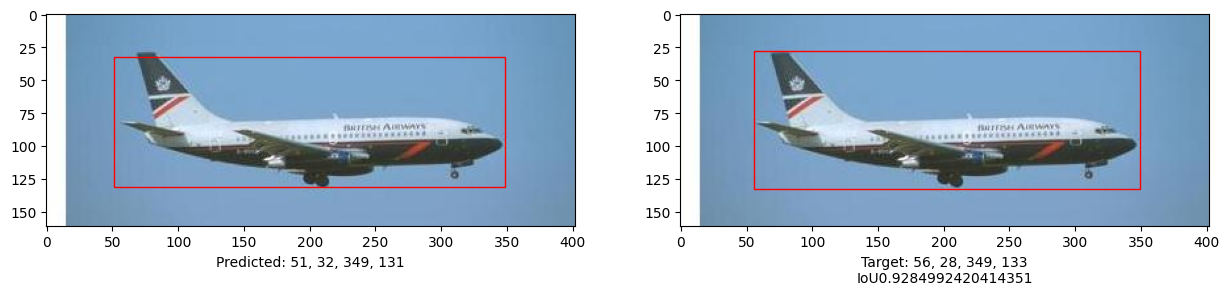

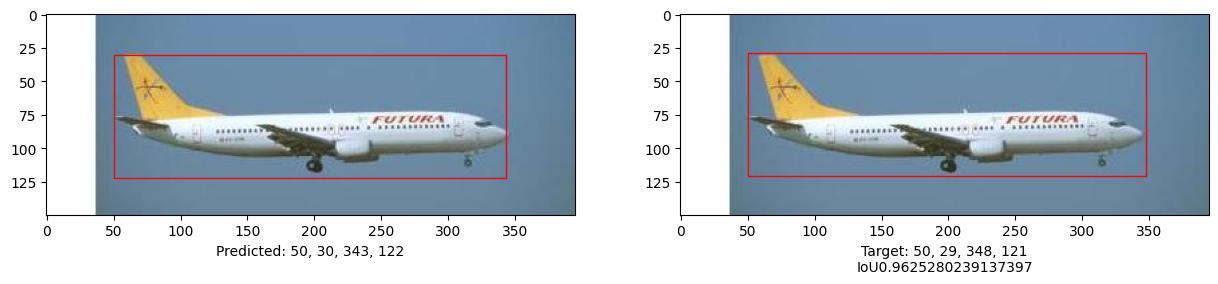

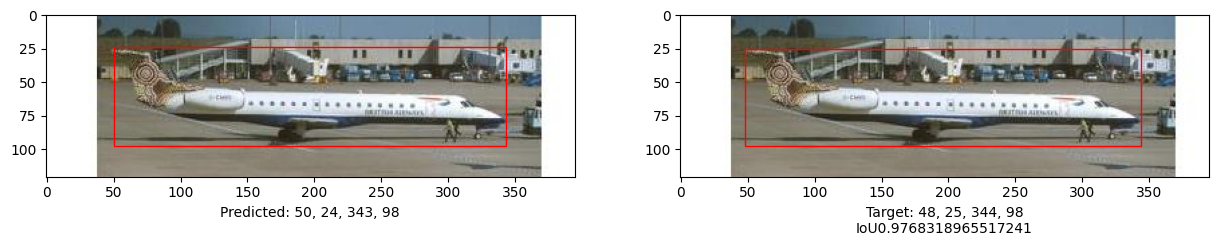

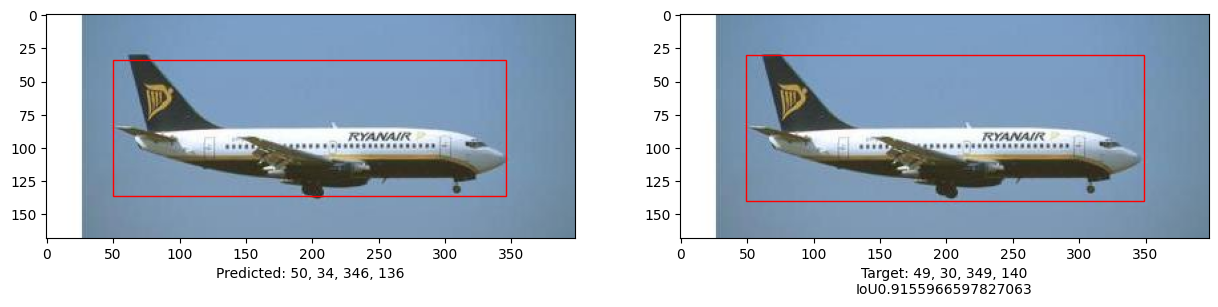

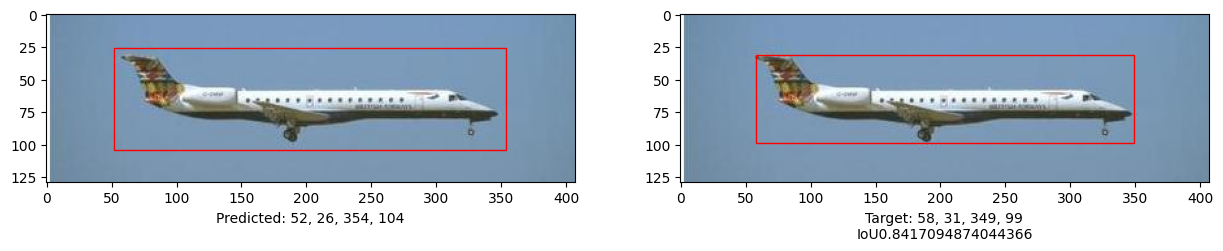

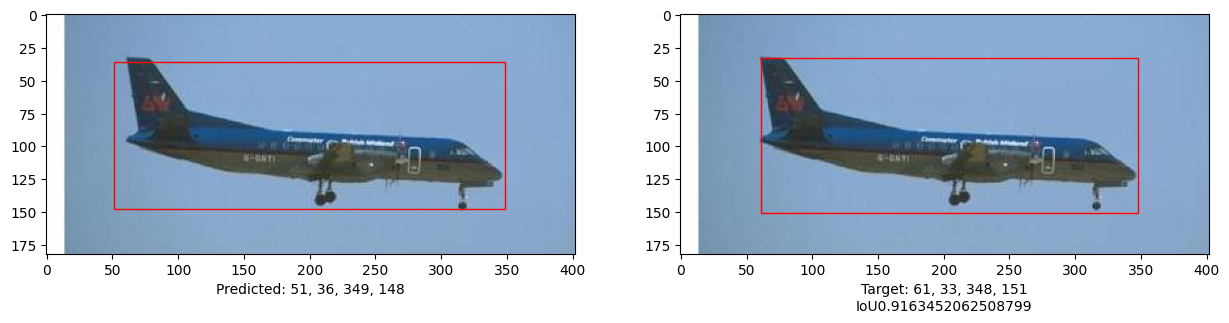

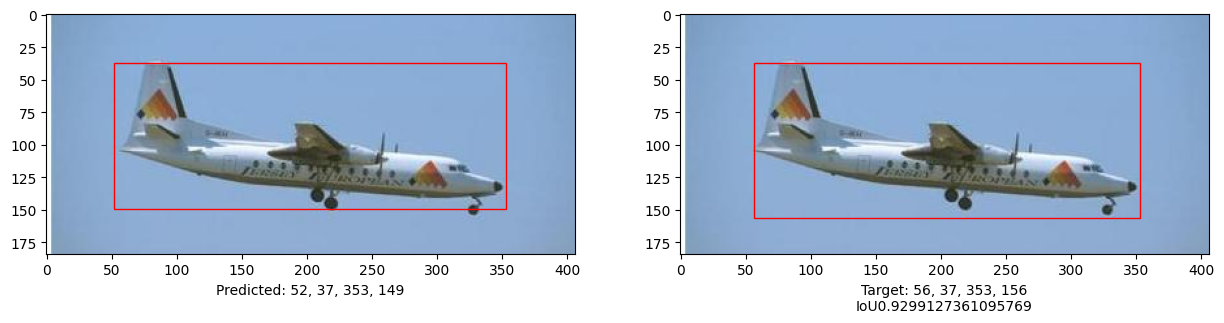

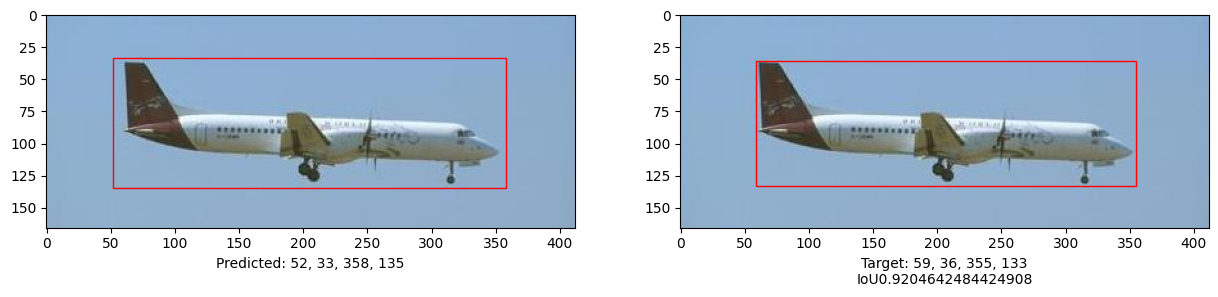

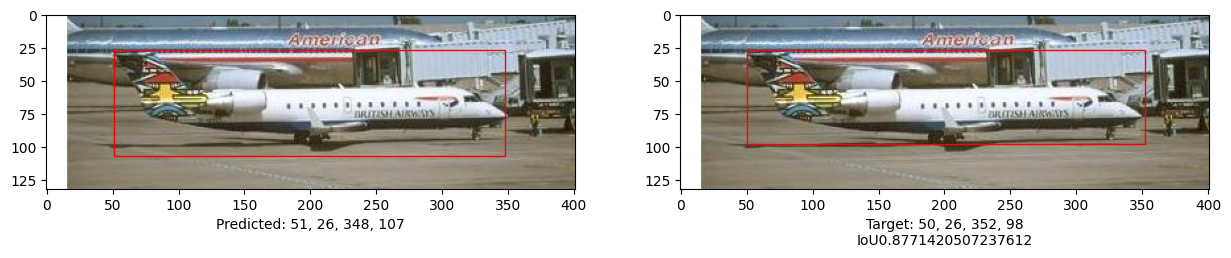

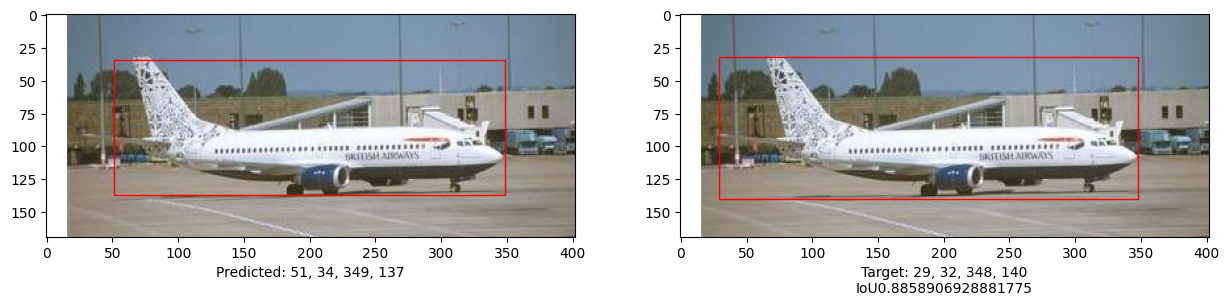

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Save the model in the current path
vit_object_detector.save("vit_object_detector.h5", save_format="h5")

# Function to calculate Intersection over Union (IoU) given two bounding boxes
def bounding_box_intersection_over_union(box_predicted, box_truth):
  """
  Function to calculate Intersection over Union (IoU) given two bounding boxes.

  Args:
      box_predicted (list): List containing [x1, y1, x2, y2] coordinates of the predicted bounding box.
      box_truth (list): List containing [x1, y1, x2, y2] coordinates of the ground-truth bounding box.

  Returns:
      float: The Intersection over Union (IoU) between the two bounding boxes.
  """
  # Get (x, y) coordinates of intersection of bounding boxes
  top_x_intersect = max(box_predicted[0], box_truth[0])
  top_y_intersect = max(box_predicted[1], box_truth[1])
  bottom_x_intersect = min(box_predicted[2], box_truth[2])
  bottom_y_intersect = min(box_predicted[3], box_truth[3])

  # Calculate area of the intersection bounding box
  intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
      0, bottom_y_intersect - top_y_intersect + 1
  )

  # Calculate area of the predicted bounding box and ground-truth bounding box
  box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
      box_predicted[3] - box_predicted[1] + 1
  )
  box_truth_area = (box_truth[2] - box_truth[0] + 1) * (box_truth[3] - box_truth[1] + 1)

  # Calculate Intersection over Union (IoU)
  iou = intersection_area / float(box_predicted_area + box_truth_area - intersection_area)

  # Return IoU
  return iou

i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
  im = input_image

  # Display the image
  ax1.imshow(im.astype("uint8"))
  ax2.imshow(im.astype("uint8"))

  # Resize the input image to the required size
  input_image = cv2.resize(
      input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
  )
  input_image = np.expand_dims(input_image, axis=0)
  preds = vit_object_detector.predict(input_image)[0]

  (h, w) = (im).shape[0:2]

  top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)
  bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)
  box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

  # Create the bounding box for predicted object
  rect = patches.Rectangle(
      (top_left_x, top_left_y),
      bottom_right_x - top_left_x,
      bottom_right_y - top_left_y,
      facecolor="none",
      edgecolor="red",
      linewidth=1,
  )
  # Add the bounding box to the image
  ax1.add_patch(rect)
  ax1.set_xlabel(
      "Predicted: "
      + str(top_left_x)
      + ", "
      + str(top_left_y)
      + ", "
      + str(bottom_right_x)
      + ", "
      + str(bottom_right_y)
  )

  top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)
  bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)
  box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

  mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)

  # Create the bounding box for ground truth object
  rect = patches.Rectangle(
      (top_left_x, top_left_y),
      bottom_right_x - top_left_x,
      bottom_right_y - top_left_y,
      facecolor="none",
      edgecolor="red",
      linewidth=1,
  )
  # Add the bounding box to the image
  ax2.add_patch(rect)
  ax2.set_xlabel(
      "Target: "
      + str(top_left_x)
      + ", "
      + str(top_left_y)
      + ", "
      + str(bottom_right_x)
      + ", "
      + str(bottom_right_y)
      + "\n"
      + "IoU"
      + str(bounding_box_intersection_over_union(box_predicted, box_truth))
  )
  i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()
